# Prj_GAN (Generative AI)

You have been given a simulated dataset and a pre-trained generative model (see readme.txt).

- The training data is in images.csv and coords.csv.
- The generative model is in WGAN.model.

- Your first task is to use the pre-trained model to generate a new image.
- Your second task is to re-train your own WGAN model using a suitable optimization strategy. For the second task, describe statistics for benchmarking your generative model.


## Task 1: Inference using pre-trained model


### preparing

- import libs as needed
- peek folder structure
- prepare data


In [1]:
# model utils
from generative_model import WGAN_SIMPLE, eval_model
from process_data import load_csv_with_cache, MinMaxScaler
from plotting import plot_mean_std

# paths
import os.path as osp
from glob import glob

# computation
import numpy as np
import pandas as pd
import torch

# graphing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_ROOT = '../DATA'
MODEL_ROOT = '../MODEL'
data_paths, model_paths = glob(f'{DATA_ROOT}/*'), glob(f'{MODEL_ROOT}/*')
print(f'data paths: {data_paths}\n'
      f'model paths: {model_paths}')

data paths: ['../DATA/Rayleigh_P30_downsampled_flat.csv', '../DATA/downsampled_points.csv', '../DATA/downsampled_points.csv.pkl', '../DATA/Rayleigh_P30_downsampled_flat.csv.pkl']
model paths: ['../MODEL/WGAN_lr0.0002_b128_49.pt', '../MODEL/WGAN_lr0.0005_0.9_b128_149.pt', '../MODEL/WGAN_lr0.0002_0.5_b128_149.pt', '../MODEL/WGAN_lr0.0002_b32_199.pt', '../MODEL/WGAN_lr0.0002_0.9_b128_149.pt', '../MODEL/WGAN_lr0.0002_b128_149.pt', '../MODEL/WGAN_lr0.0001_0.9_b128_49.pt', '../MODEL/WGAN_lr0.0002_0.5_b128_99.pt', '../MODEL/WGAN_lr0.0001_0.5_b128_199.pt', '../MODEL/WGAN_lr0.0002_b64_49.pt', '../MODEL/WGAN_lr0.0005_0.9_b128_49.pt', '../MODEL/WGAN_lr0.0001_b64_99.pt', '../MODEL/WGAN_lr0.0001_b64_199.pt', '../MODEL/WGAN_lr0.0001_0.9_b128_199.pt', '../MODEL/WGAN_lr0.0002_0.9_b128_49.pt', '../MODEL/WGAN_lr0.0001_0.5_b128_99.pt', '../MODEL/WGAN_lr0.0002_b64_149.pt', '../MODEL/WGAN_lr0.0002_b32_99.pt', '../MODEL/WGAN_lr0.0002_b32_49.pt', '../MODEL/WGAN_lr0.0002_b64_199.pt', '../MODEL/WGAN_lr0.0001_0

In [3]:
data = load_csv_with_cache(f'{DATA_ROOT}/Rayleigh_P30_downsampled_flat.csv')
cord = load_csv_with_cache(f'{DATA_ROOT}/downsampled_points.csv')
avg = np.mean(data, axis=0)

scaler = MinMaxScaler()
scaler.fit(data)

normed_data = scaler.transform(data)
normed_data.shape, avg.shape, cord.shape

((15400, 2382), (2382,), (2382, 2))

### model inference

- load model (in a bit hacky way)
- infer a new distribution


In [5]:
model = WGAN_SIMPLE(ndim=2382, nhid=200)
checkpoint = torch.load(f'{MODEL_ROOT}/WGAN_SIMPLE_epoch199.model')
print(checkpoint.keys())
pretrained_dict = {
    k.replace("model.", ""): v
    for k, v in checkpoint["model_state_dict"].items()
}
model.load_state_dict(pretrained_dict)

dict_keys(['epoch', 'model_state_dict', 'gen_optimizer_state_dict', 'dist_optimizer_state_dict'])


<All keys matched successfully>

In [6]:
with torch.no_grad():
    model.eval()
    fake_data = model.generate()

### plotting results


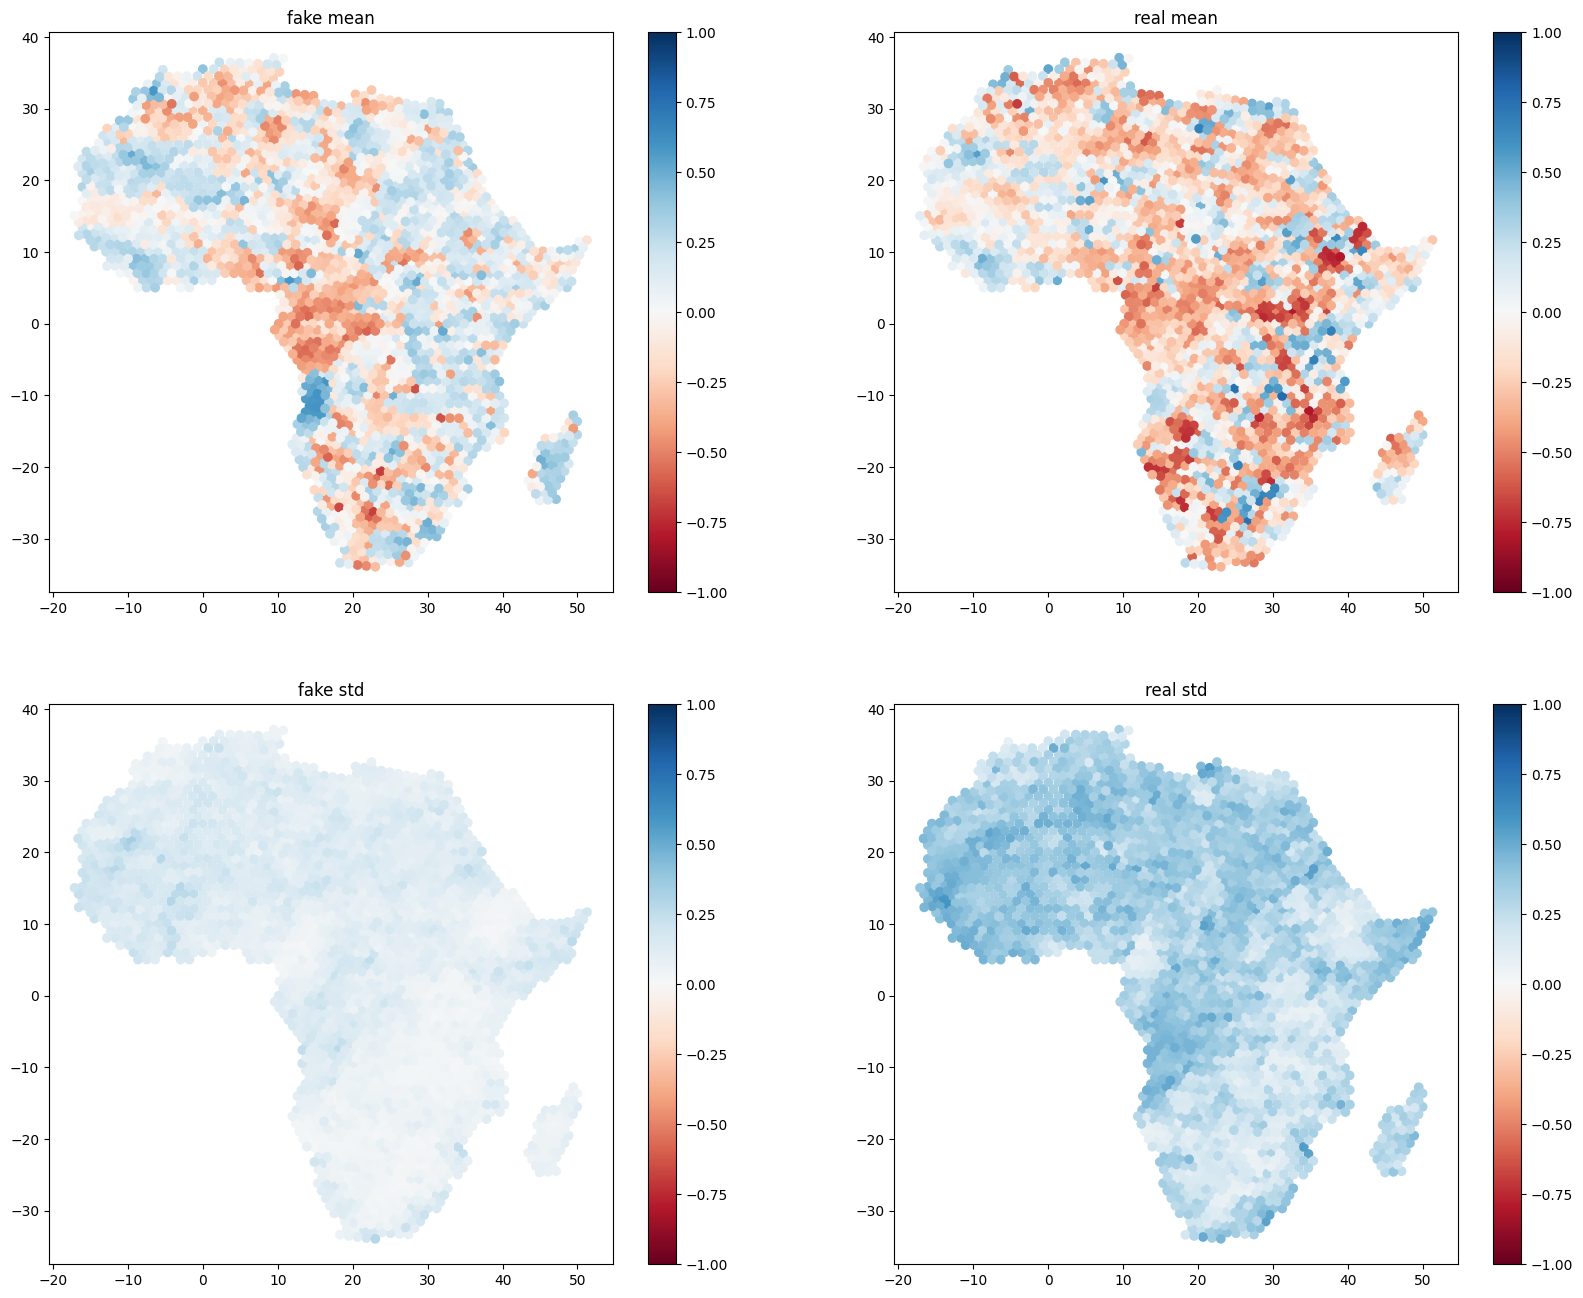

In [7]:
plot_mean_std(fake_data, normed_data, cord)

### visualize distribution


(0.2324189913650064, 0.1993559996691759, 0.2933300919935762)

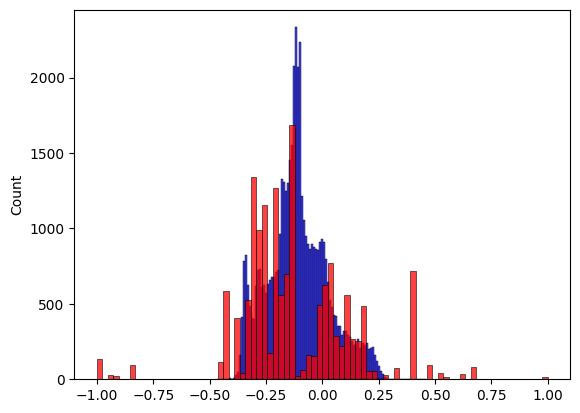

In [8]:
sns.histplot(fake_data[:, 0], color='b')
sns.histplot(normed_data[:, 0], color='r')
eval_model(model, normed_data)

(50000,) (15400,)


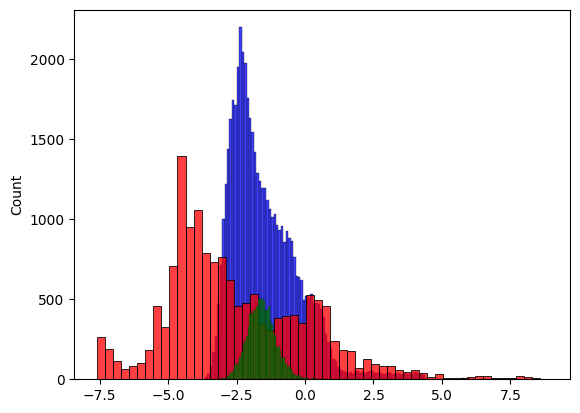

In [9]:
with torch.no_grad():
    model.eval()
    _fake = model.disc(torch.Tensor(fake_data)).numpy().flatten()
    _real = model.disc(torch.Tensor(normed_data)).numpy().flatten()
    _random = model.disc(torch.randn(10000, 2382)).numpy().flatten()
    print(_fake.shape, _real.shape)
    sns.histplot(_fake, color='b')
    sns.histplot(_real, color='r')
    sns.histplot(_random, color='g')

## Task 2: Training our own WGAN model

- saved in a seperate file, see `train.py`


In [10]:
model = torch.load(f'{MODEL_ROOT}/WGAN_lr0.0002_0.9_b128_99.pt')

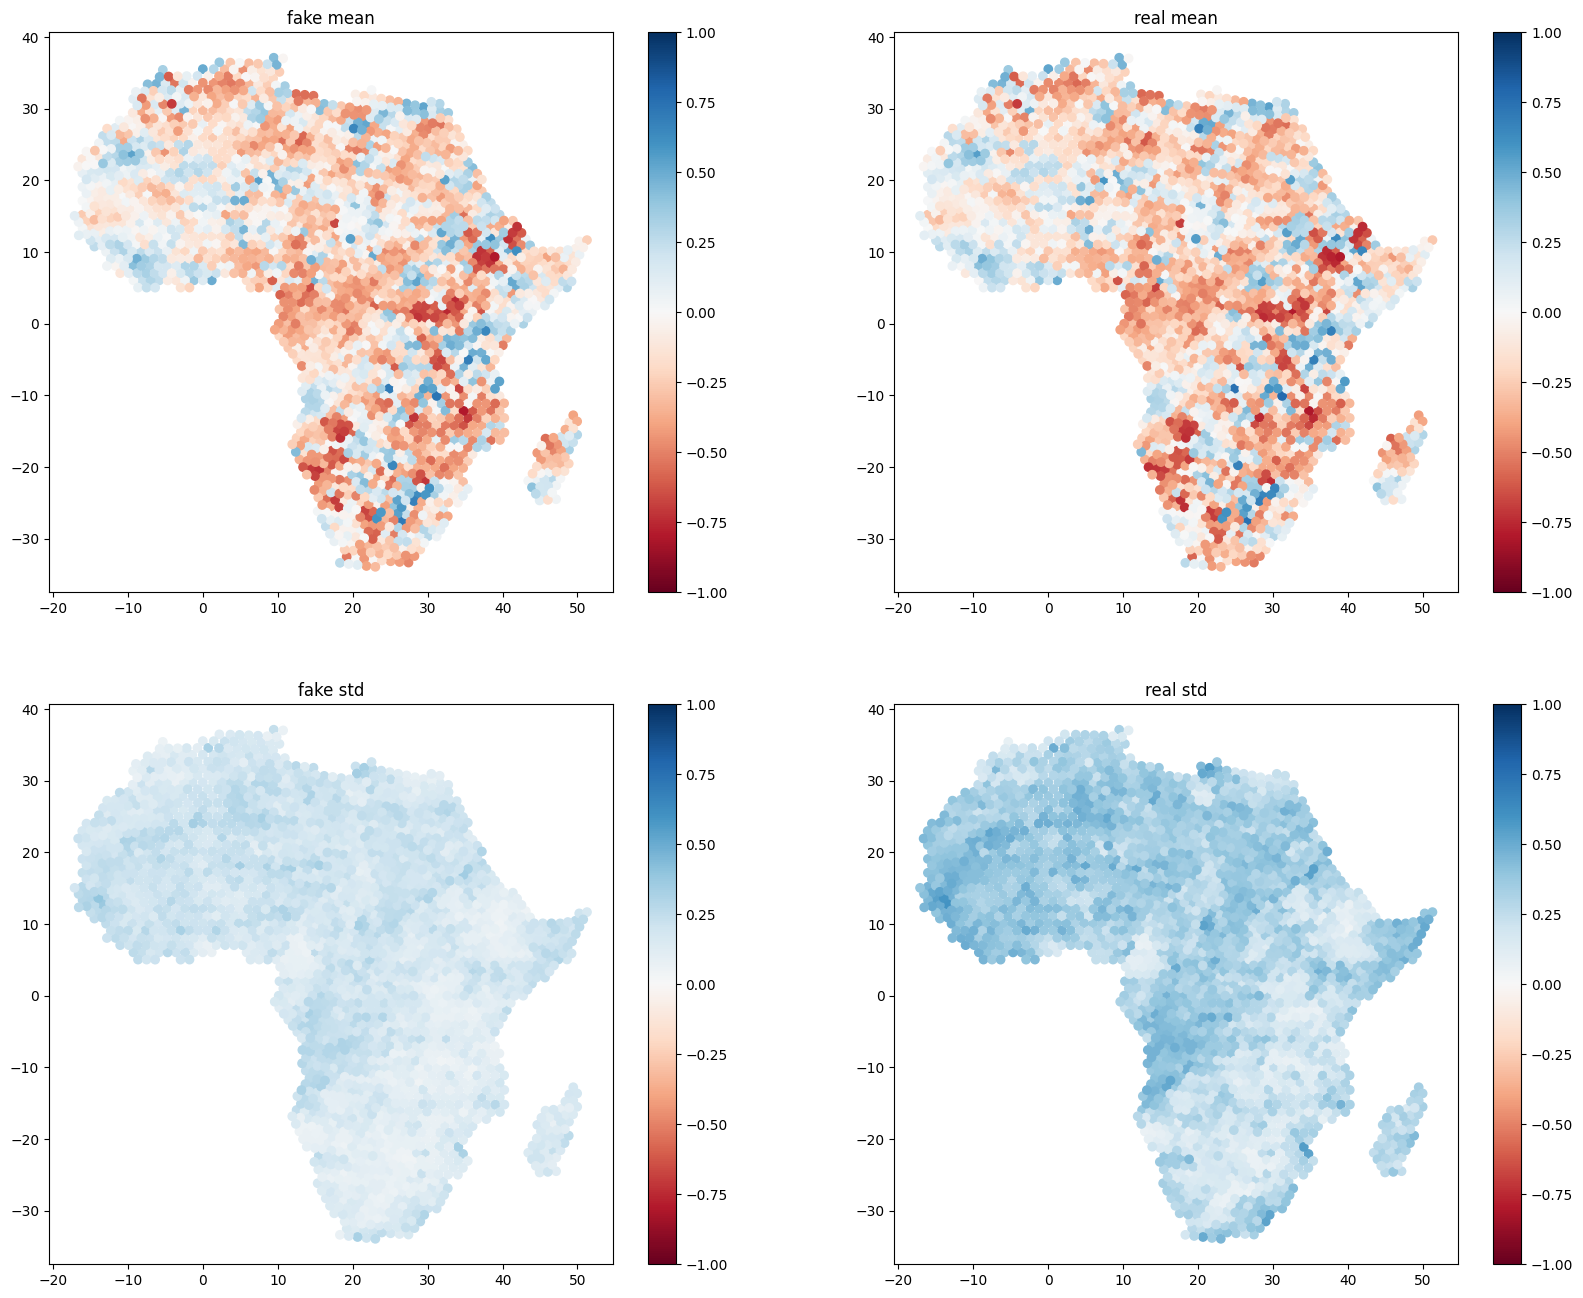

In [11]:
with torch.no_grad():
    model.eval()
    new_fake_data = model.generate()

plot_mean_std(new_fake_data, normed_data, cord)

(0.016379526547664728, 0.12923719034410247, 0.1032254027474875)

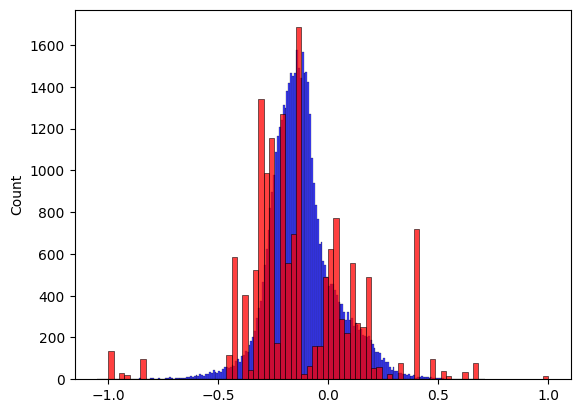

In [12]:
sns.histplot(new_fake_data[:, 0], color='b')
sns.histplot(normed_data[:, 0], color='r')
eval_model(model, normed_data)

(50000,) (15400,)


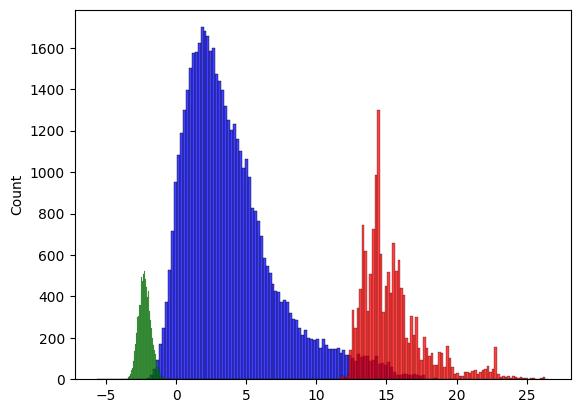

In [13]:
with torch.no_grad():
    model.eval()
    model.to('cpu')
    _fake = model.disc(torch.Tensor(new_fake_data)).numpy().flatten()
    _real = model.disc(torch.Tensor(normed_data)).numpy().flatten()
    _random = model.disc(torch.randn(10000, 2382)).numpy().flatten()
    print(_fake.shape, _real.shape)
    sns.histplot(_fake, color='b')
    sns.histplot(_real, color='r')
    sns.histplot(_random, color='g')